# 勾配ブースティング(gradient boosting)
- 勾配情報を使って、徐々に残差を減らしていく
- 通常は弱学習器として決定木を使う

## 勾配ブースティング(回帰)
- 最初はyの平均を出力する(最初の損失関数が最小になるため)
- 残差を目的変数をするが、これは損失の勾配を学習していたということである

### データ準備

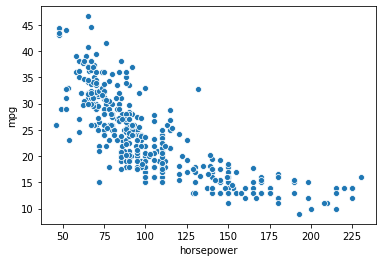

In [11]:
import seaborn as sns
df = sns.load_dataset("mpg")
df.dropna(inplace=True)
X = df["horsepower"].values.reshape(-1, 1)
y = df["mpg"].values
sns.scatterplot(x=df["horsepower"], y=df["mpg"])

### スクラッチで実装

In [9]:
from sklearn.tree import DecisionTreeRegressor

# 今はNumpyしか対応していないコード
class MyGradientBoostingRegressor:
    
    def __init__(self, learning_rate=0.03, n_estimators=100, max_depth=1, random_state=0):
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.estimators = []
        
    def fit(self, X, y):
        
        self.F0 = y.mean()
        Fb = self.F0
        
        for _ in range(self.estimators):
            # 残差を計算
            r = y - Fb
            estimator = DecisionTreeRegressor(max_depth = self.max_depth, random_state = self.random_state)
            estimator.fit(X, r)# yではなくr
            weight = estimator.predict(X)
            Fb += self.learning_rate * weight
            self.estimators.append(estimator)
            
    def predict(self, X):
        
        Fb = self.F0
        
        for estimator in self.estimators:
            Fb += self.learning_rate * estimator.pridint(X)
        
        return Fb
            

### sklearnのGradientBoostingRegressorを使う

sklearn.ensemble.GradientBoostingRegressorクラス
1. インスタンス生成
    - n_estimators: モデルの数
    - learning_rate: 学習率
2. .fit(X, y)で学習
3. .predict(X)で予測

In [20]:
from sklearn.ensemble import GradientBoostingRegressor
gbr = GradientBoostingRegressor(max_depth=1, learning_rate=0.03, random_state=0).fit(X, y)
gbr.predict(X)

array([17.95434839, 15.74535562, 15.74535562, 15.74535562, 16.96376992,
       15.74535562, 15.74535562, 15.74535562, 15.74535562, 15.74535562,
       15.74535562, 15.74535562, 15.74535562, 15.74535562, 23.01512881,
       23.01512881, 22.21547999, 24.54754893, 24.54754893, 31.96655862,
       24.54754893, 24.54754893, 23.01512881, 20.76151767, 24.54754893,
       15.74535562, 15.74535562, 15.74535562, 15.74535562, 24.54754893,
       24.54754893, 23.01512881, 20.76151767, 20.76151767, 20.76151767,
       24.54754893, 20.76151767, 15.74535562, 15.74535562, 15.74535562,
       15.74535562, 15.74535562, 15.74535562, 15.74535562, 20.76151767,
       27.71424635, 20.76151767, 24.54754893, 24.54754893, 24.54754893,
       31.61939691, 27.71424635, 31.96655862, 31.61939691, 31.96655862,
       31.61939691, 23.01512881, 27.71424635, 31.96655862, 24.54754893,
       24.54754893, 15.74535562, 15.74535562, 15.74535562, 15.74535562,
       15.74535562, 15.74535562, 15.74535562, 15.74535562, 15.74

最初に作られたモデルを見てみる

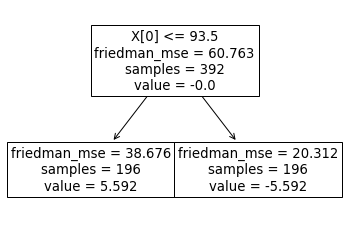

In [16]:
from sklearn.tree import plot_tree
model = gbr.estimators_[0][0] # ２個目は[1][0]
_ = plot_tree(model)

全てのモデルの合計が予測値と等しいかを見てみる

In [24]:
results = []
idx = 0
lr = 0.03
for t in gbr.estimators_:
    result = t[0].predict([X[idx]])
    results.append(result*lr)

import numpy as np
F0 = np.mean(y)
Fb = F0 + np.cumsum(results)[-1]
Fb

17.95434839052103

## 勾配ブースティング(分類)
- 最初はyの平均の対数オッズ比
- 学習するのは回帰の決定木
- シグモイド関数で確率にする

### データ準備

In [32]:
from sklearn.preprocessing import OrdinalEncoder
# データ準備
df = sns.load_dataset('titanic')
df.dropna(inplace=True)

# X, yを作成
X = df.drop(['survived', 'alive'], axis=1)
y = df['survived']

# ラベルエンコーディング
oe = OrdinalEncoder()
# oe.set_output(transform='pandas')
cat_cols = X.select_dtypes(exclude=np.number).columns.to_list()
X[cat_cols] = oe.fit_transform(X[cat_cols])

### スクラッチで実装

In [27]:
class MyGradientBoostingClassifier:
    
    def __init__(self, learning_rate=0.03, n_estimators=100, max_depth=1, random_state=0):
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.random_state = random_state
        self.estimators = []
        
    def fit(self, X, y):
        F0 = np.log(y.mean()/(1-y.mean()))
        F0 = np.hull(len(y), F0) # F0をyと同じ長さでベクトル化
        Fb = F0
        
        for _ in range(self.n_estimators):
            p = 1 / (1 + np.exp(-Fb))
            r = y - p
            estimator = DecisionTreeRegressor(max_depth=self.max_depth, random_state=self.random_state)
            estimator.fit(X, r)
            X_leafs = np.unique(estimator.apply(X)) # Xがどの葉に落ちるのかがわかる
            leaf_ids = np.unique(X_leafs) # 葉の番号のリスト
            for leaf_id in leaf_ids:
                # 弱学習器の出力の値を計算
                fltr = X_leafs == leaf_id
                num = r[fltr].sum() # 分子
                den = (p[fltr]*(1-p[fltr])).sum() # 分母
                estimator_pred_proba = num / den
                # 弱学習器の出力を上書き
                estimator.tree_.value[leaf_id, 0, 0] = estimator_pred_proba
                # 当該データのFbを更新
                Fb[fltr] += self.learning_rate * estimator_pred_proba
            
            self.estimators.append(estimator)
            
        def predict_proba(self, X):
            
            Fb = np.full(X.shape[0], self.F0)
            
            for estimator in self.estimators:
                Fb += self.learning_rate * estimator.predict(X)
                
            return 1 / (1 + np.exp(-Fb))


### sklearnのGradientBoostingClassifierを使う

sklearn.ensemble.GradientBoostingClassifierクラス
1. インスタンス生成
    - n_estimators: モデルの数
    - learning_rate: 学習率
2. .fit(X, y)で学習
3. .predict(X)で予測


In [34]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.03, max_depth=1, random_state=0).fit(X, y)
print(f"grad boost AUC: {roc_auc_score(y, gbc.predict_proba(X)[:, 1])}")


grad boost AUC: 0.8815626291856139
